In [1]:
import numpy as np
import scipy.stats as sps
import pandas as pd
import cvxpy as cp
import itertools
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler

from utils import dict_list
from utils_actlearn.gauss import *
from utils_actlearn.mes import *
from utils_actlearn.scp_taylor import *
from utils_actlearn.scp_particle import *
from utils_plot import set_plt_settings, plot_dist, plot_boxplots

set_plt_settings()
%load_ext autoreload
%autoreload 2

# TODO -- statistical tests
https://freakonometrics.hypotheses.org/4199

In [2]:
def get_stats(results, f, fpred):
    percentiles = [0, 10, 25, 50, 75, 90, 100]
    for p in percentiles:
        results.add(f'pctl_{p}', np.percentile(fpred, p))
    results.add('mean', np.mean(fpred))
    results.add('std', np.std(fpred))
    # comparison stats
    results.add('ttest', sps.ttest_ind(f, fpred).pvalue)
    results.add('komolgorov', sps.ks_2samp(f, fpred).pvalue)
    
    return results

# Test active learning approach

## Load data

In [3]:
D = 10
X = np.load('../data/pca_encoding.npy')[:,:D]
n, d = X.shape
# columns=['index', sample_num', 'operating_cost', 'market_rev', 'runtime'
f = pd.read_csv('../data/combined_hvac.csv', header=None).to_numpy()[:,2]

In [4]:
fscale = StandardScaler().fit_transform(f.reshape(-1,1)).flatten()
Xscale = StandardScaler().fit_transform(X)

In [5]:
n0, N = 2, 25

## Train surrogate model

### Brute force

In [102]:
fpreds_brute = mes(None, X=Xscale, f=fscale, N=N, n0=n0, l=7)

100%|███████████████████████████████████████████| 23/23 [00:02<00:00,  8.68it/s]


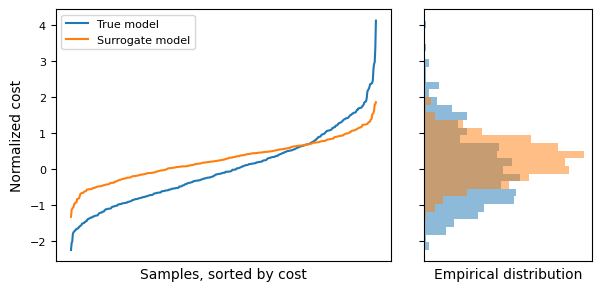

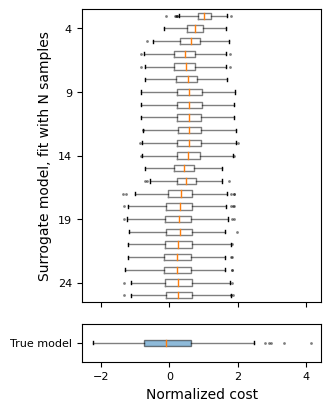

In [103]:
plot_dist(fscale, fpreds_brute[N-1], bins=30)
plot_boxplots(fscale, fpreds_brute)

### Taylor approximation SCP

In [100]:
fpreds_taylor = mes(scp_taylor, X=Xscale, f=fscale, N=N, n0=n0, l=2.5, scp_param_override={'rho0':0.01})

100%|███████████████████████████████████████████| 23/23 [00:07<00:00,  3.22it/s]


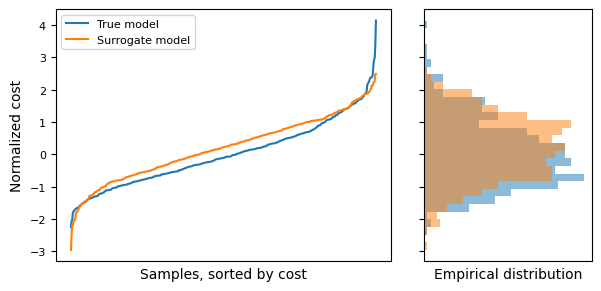

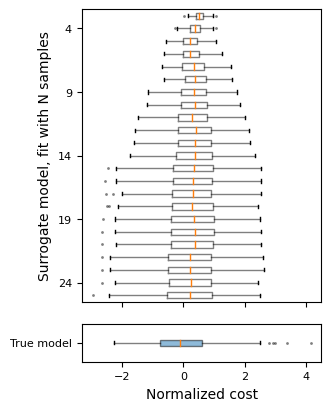

In [101]:
plot_dist(fscale, fpreds_taylor[N-1], bins=30)
plot_boxplots(fscale, fpreds_taylor)

### Particle method approximation SCP

In [76]:
fpreds_particle = mes(scp_particle, X=Xscale, f=fscale, N=N, n0=n0, l=2.5)

100%|███████████████████████████████████████████| 23/23 [00:33<00:00,  1.46s/it]


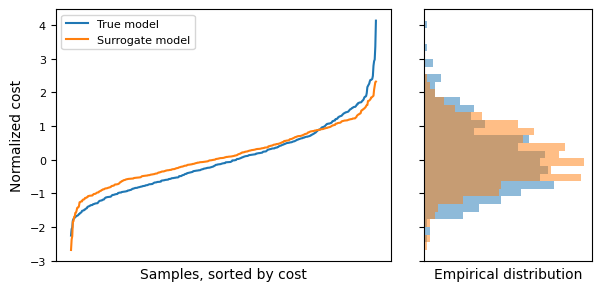

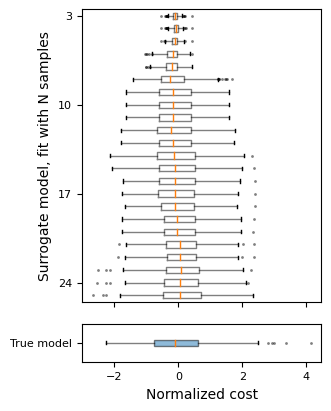

In [97]:
plot_dist(fscale, fpreds_particle[N-1], bins=30)
plot_boxplots(fscale, fpreds_particle)